<a href="https://colab.research.google.com/github/jayaw2/Pattern-Discovery/blob/main/Pattern_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Discovery

## Clustering and Fast Retrieval

In [2]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1 [388 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 1s (524 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 120509 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a14.0.0-1ubuntu1_amd64.d

In [3]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

11490434/11490434 [==============================] - 0s 0us/step


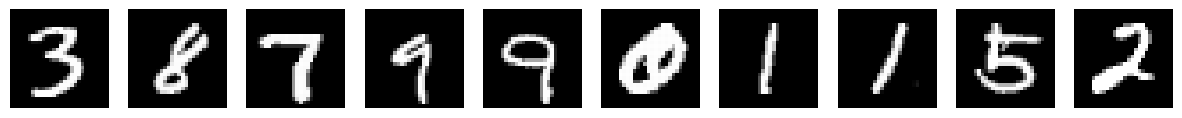

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [5]:
## Helper functions

# Returns the purity of the clustering according to labels,
# and the label counts of each cluster
def get_purity(labels, cluster_idx):
  nclasses = int(max(labels)+1)
  nidx = int(max(cluster_idx)+1)
  counts = np.zeros((nidx, nclasses), np.int32)
  for i in range(len(labels)):
    c = labels[i]
    idx = cluster_idx[i]
    counts[idx, c]+=1
  purity = np.sum(np.max(counts, axis=1))/len(cluster_idx)
  return purity, counts

# Returns an index list that can be used to re-order the counts according to
# which label is most common
def get_cluster_order(counts):
  idx = np.argmax(counts, axis=1)
  idx = np.argsort(idx)
  return idx

###Clustering

Purity for K=10: 0.6094


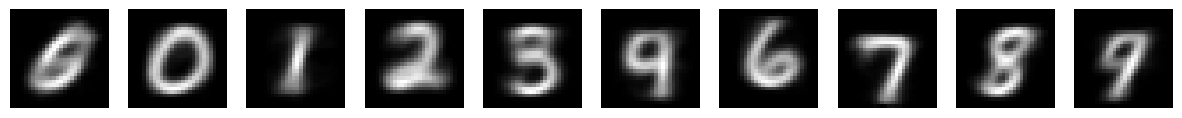

Average Distance for K=10: 39.6195
Purity for K=20: 0.7210


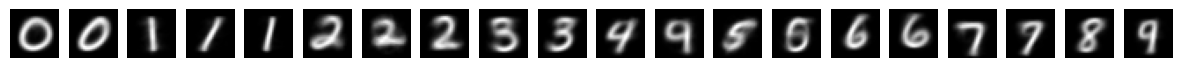

Average Distance for K=20: 35.5396
Purity for K=30: 0.7517


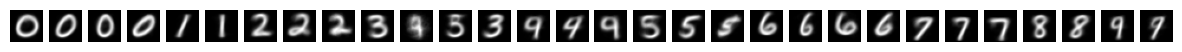

Average Distance for K=30: 33.4579
Purity for K=40: 0.7713


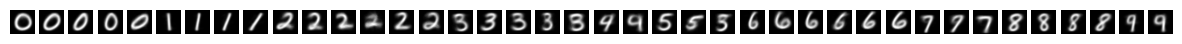

Average Distance for K=40: 32.1930
Purity for K=50: 0.7998


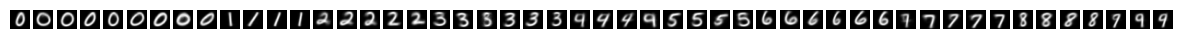

Average Distance for K=50: 31.0369
Purity for K=60: 0.8214


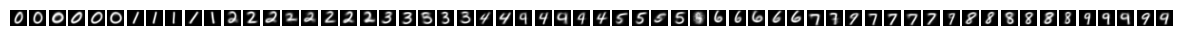

Average Distance for K=60: 30.1816
Purity for K=70: 0.8437


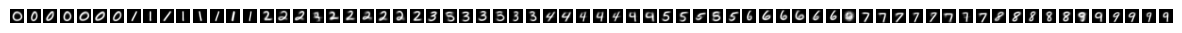

Average Distance for K=70: 29.7405
Purity for K=80: 0.8588


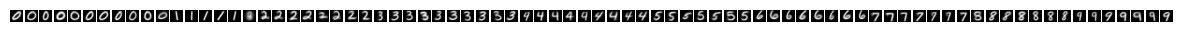

Average Distance for K=80: 29.0738
Purity for K=90: 0.8641


Average Distance for K=90: 28.7147
Purity for K=100: 0.8551


Average Distance for K=100: 28.4088


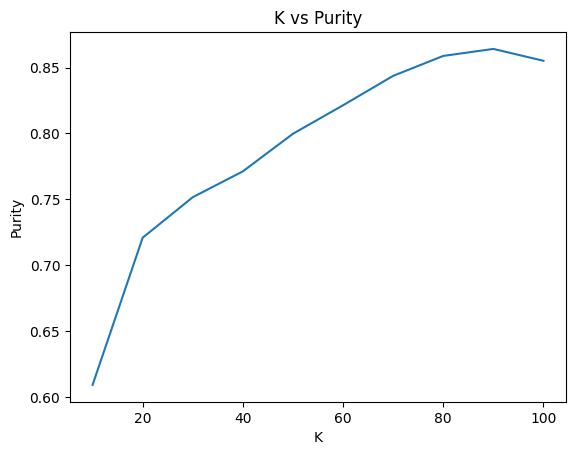

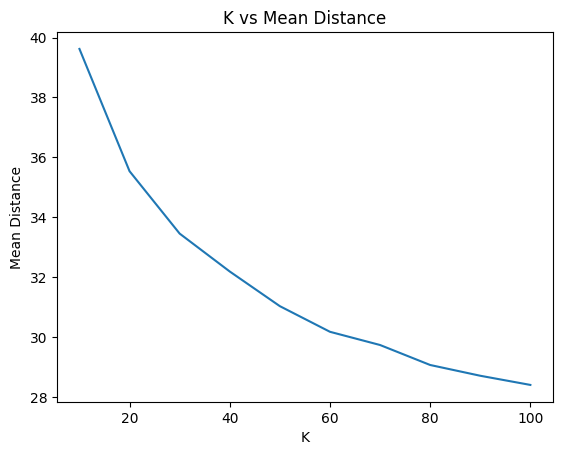

In [6]:
# set dimensions
dim = x_train.shape[1]

# Set the number of clusters
clusters =  [10, 20, 30,40,50,60,70,80,90, 100]

purity_k = []
mean_k = []


for K in clusters:
  # Initialize the k-means clustering object
  kmeans = faiss.Kmeans(dim, K, niter=20)

  # Train the k-means model
  kmeans.train(x_train)

  # Assign each data point to a cluster
  dist, cluster_idx = kmeans.index.search(x_test, 1)

  # Record and print Purity
  purity, counts = get_purity(y_test, cluster_idx)
  print(f"Purity for K={K}: {purity:.4f}")
  purity_k.append(purity)

  #Get Cluster indexes & Display the centroids
  idx = get_cluster_order(counts)
  display_mnist(kmeans.centroids[idx, :],1,K)

  # Record and print Average Distance
  mean_distance = dist.mean()
  mean_k.append(mean_distance)
  print(f"Average Distance for K={K}: {mean_distance:.4f}")


#Plot K vs Purity
plt.plot(clusters, purity_k)
plt.title('K vs Purity')
plt.xlabel('K')
plt.ylabel('Purity')
plt.show()

# Plot K vs Mean Distance
plt.plot(clusters, mean_k)
plt.title('K vs Mean Distance')
plt.xlabel('K')
plt.ylabel('Mean Distance')
plt.show()


### Fast Retrieval

In [7]:
## Brute Force (IndexFlatL2)

# set dimensions
dim = x_train.shape[1]

start_time = time.time()

# Initialize the index for Brute Force

index = faiss.IndexFlatL2(dim)

# Add Data & Print time to add

index.add(x_train)
add_time = time.time() - start_time
print(f"Time to add data: {add_time:.4f} seconds")


# Perform Search and Compute Time required
s = time.time()
dist, idx = index.search(x_test, 1)
search_time = time.time() - s
print(f"Time to perform search: {search_time:.4f} seconds")

total_time = add_time + search_time

print(f"Total BF time: {total_time:.4f} seconds")

# Compute Test Error

y_pred = y_train[idx.flatten()]
test_error = 1 - np.mean(y_pred == y_test)
print(f"Test Error: {test_error:.4f}")




Time to add data: 0.3251 seconds
Time to perform search: 13.6929 seconds
Total BF time: 14.0181 seconds
Test Error: 0.0331


In [8]:
## LSH

# set dimensions
dim = x_train.shape[1]

start_time = time.time()
# Initialize the index for LSH

nbits = dim*2
index_lsh = faiss.IndexLSH(dim, nbits)

# Add Data & Print time to add

index_lsh.add(x_train)
print(f"Time to add data: {time.time() - start_time:.4f} seconds")


# Perform Search and Compute Time required
s = time.time()
dist_lsh, idx_lsh = index_lsh.search(x_test, 1)
print(f"Time to perform search: {time.time() - s:.4f} seconds")

# Compute Test Error

y_pred = y_train[idx_lsh.flatten()]
test_error = 1 - np.mean(y_pred == y_test)
print(f"Test Error: {test_error:.4f}")





Time to add data: 2.8380 seconds
Time to perform search: 14.9305 seconds
Test Error: 0.0318


## Estimating PDFs

Mounted at /content/drive


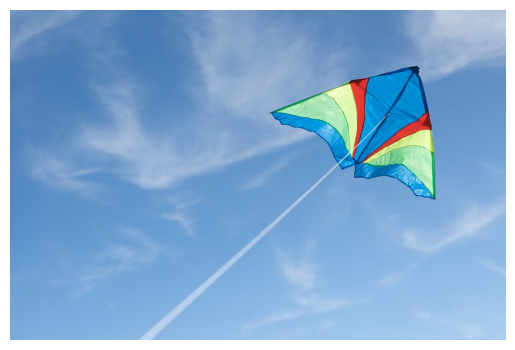

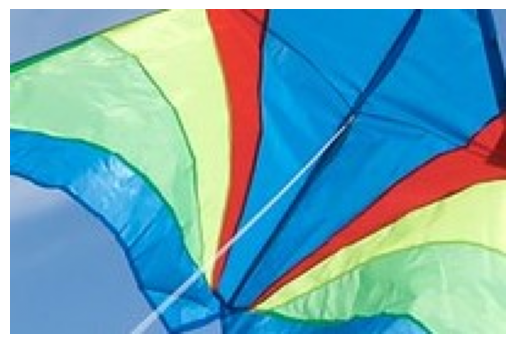

In [9]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/"
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
plt.imshow(im)
plt.axis('off')
plt.show()
plt.imshow(crop)
plt.axis('off')
plt.show()

In [10]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

#### Method 1: Per-dimension discrete pdf

In [11]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i

    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p
  # loop through values
  for value in x:
    # increment element of p corresponding to each value
    p[value] += 1
  # divide by sum of p
  p /= np.sum(p)
  return p

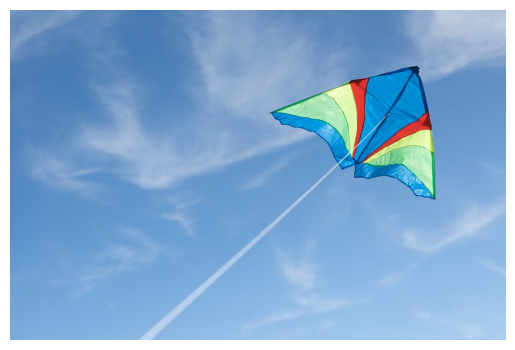

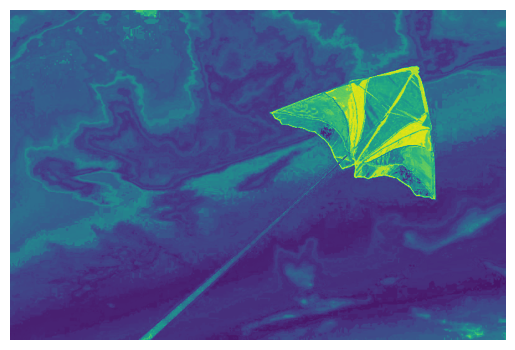

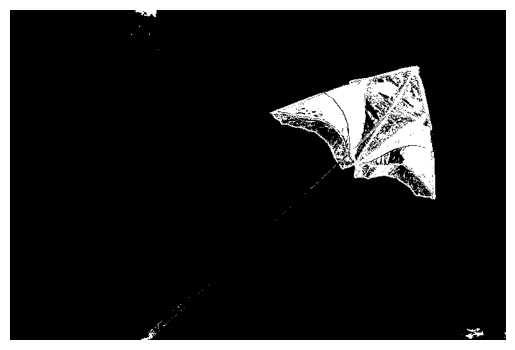

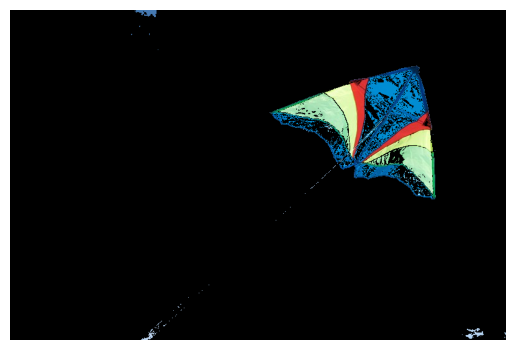

In [12]:
# set number of bins K
K = 150

# reshape pixels to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# convert continuous values to discrete values ranging from 0 to K-1
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
full_discrete = np.minimum((full_pixels * K).astype(int), K - 1)
crop_discrete = np.minimum((crop_pixels * K).astype(int), K - 1)

# get pdf for each dimension using estimate_discrete_pdf
pdfs_crop = []
pdfs_full = []
for d in range(3):
    pdfs_crop.append(estimate_discrete_pdf(crop_discrete[:, d], K))
    pdfs_full.append(estimate_discrete_pdf(full_discrete[:, d], K))

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        pixel = full_discrete[i * im.shape[1] + j]
        score_map[i, j] = np.sum([np.log(pdfs_crop[d][pixel[d]] / pdfs_full[d][pixel[d]]) for d in range(3)])

# display
thresh = 2
display_score_maps(im, score_map, thresh)

#### Method 2: K-means

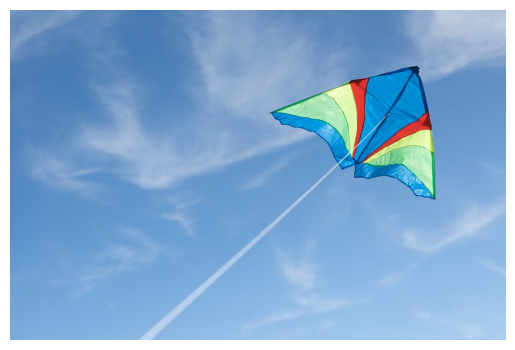

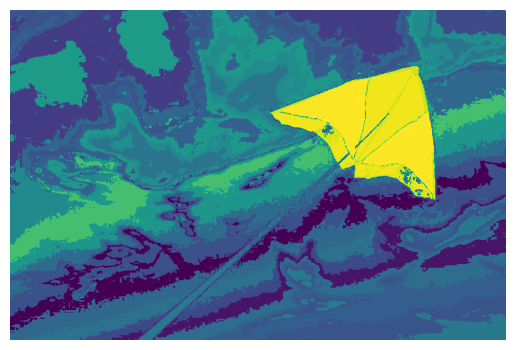

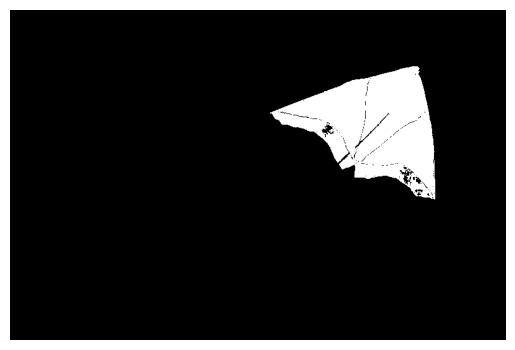

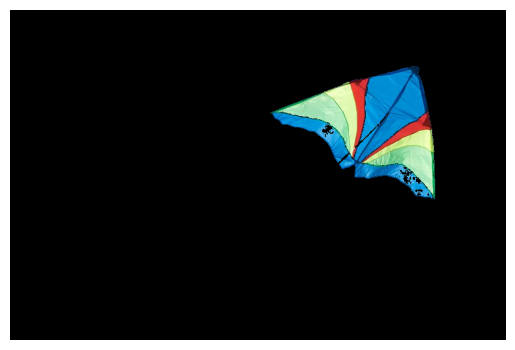

In [13]:
import faiss

# set K
K = 32
# reshape pixels to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# discretize all three color channels together using KMeans
kmeans = faiss.Kmeans(3, K, niter=20)
kmeans.train(full_pixels)
_, im_cluster_ids = kmeans.index.search(full_pixels, 1)
_, crop_cluster_ids = kmeans.index.search(crop_pixels, 1)

# get pdf over discrete values
pdf_full = estimate_discrete_pdf(im_cluster_ids.flatten(), K)
pdf_crop = estimate_discrete_pdf(crop_cluster_ids.flatten(), K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        cluster_id = im_cluster_ids[i * im.shape[1] + j]
        score_map[i, j] = np.log(pdf_crop[cluster_id] / pdf_full[cluster_id])

# display
thresh = 2
display_score_maps(im, score_map, thresh)


#### Method 3: Gaussian Mixture Model

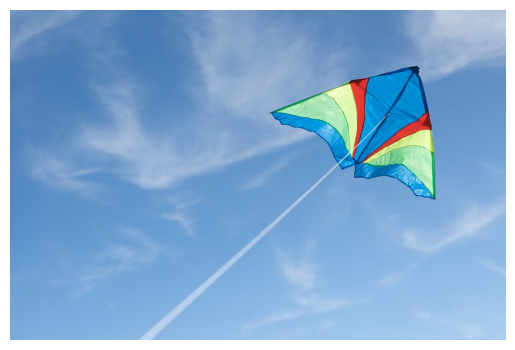

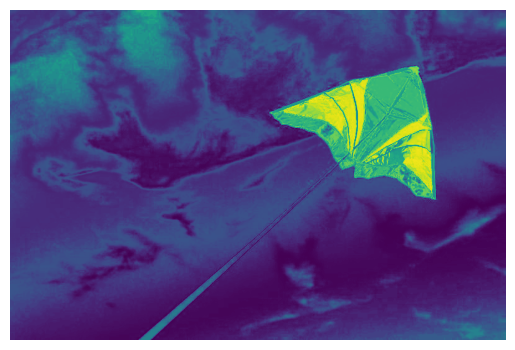

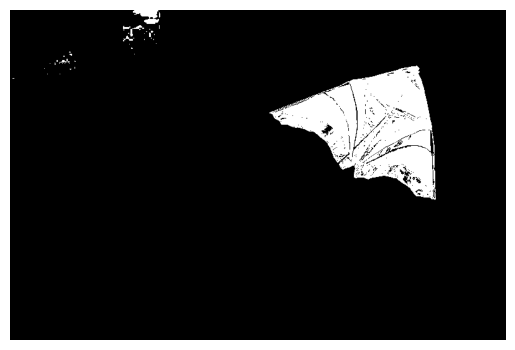

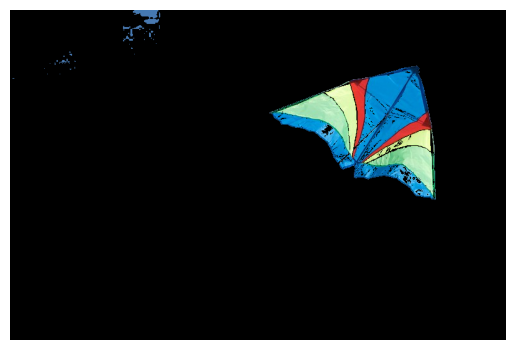

In [17]:
from sklearn.mixture import GaussianMixture

# reshape to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# get joint pdf using GMMs
gmm_full = GaussianMixture(n_components=4, covariance_type='diag')
gmm_full.fit(full_pixels)

gmm_crop = GaussianMixture(n_components=4, covariance_type='diag')
gmm_crop.fit(crop_pixels)

# estimate score for each pixel in full image according to log pdfs
log_pdf_full = gmm_full.score_samples(full_pixels)
log_pdf_crop = gmm_crop.score_samples(full_pixels)
score_map = log_pdf_crop - log_pdf_full
score_map = score_map.reshape(im.shape[:2])

# display
thresh = 1
display_score_maps(im, score_map, thresh)


## PCA and Data Compression

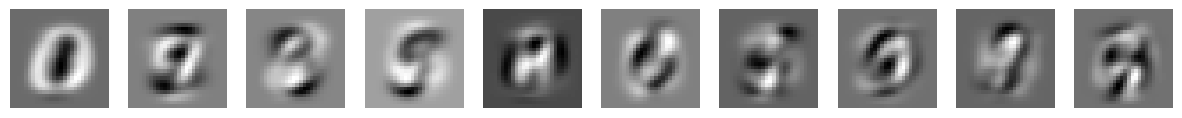

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import faiss

(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the principal components
pca = PCA()
pca.fit(x_train)

# Display First 10 Components
display_mnist(pca.components_[:10], 1, 10)


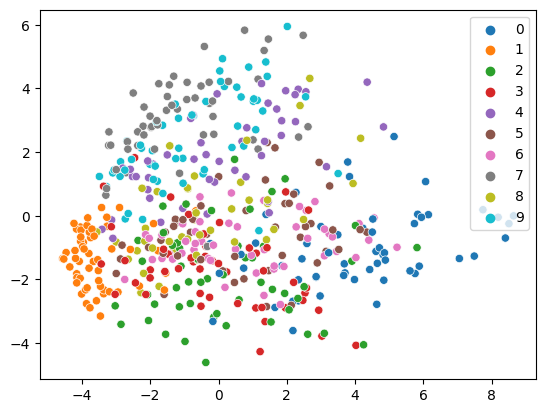

In [18]:
# Scatter plot of first two PCA dimensions
import seaborn as sns
pca_s = PCA(n_components=2)
pca_s.fit(x_train[train_indices['s']])

# Project data onto first two principal components
pca_data = pca_s.transform(x_train[train_indices['s']])

# Create scatter plot of PCA data
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=y_train[train_indices['s']], palette='tab10')
plt.show()


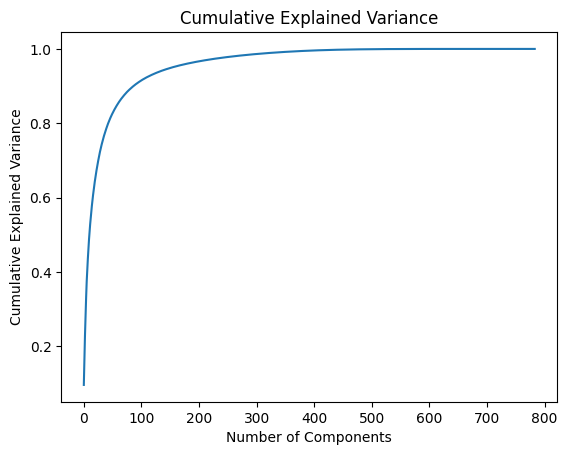

In [19]:
# Plot cumulative explained variance

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()




88
(50000, 784)
(50000, 88)
(10000, 88)


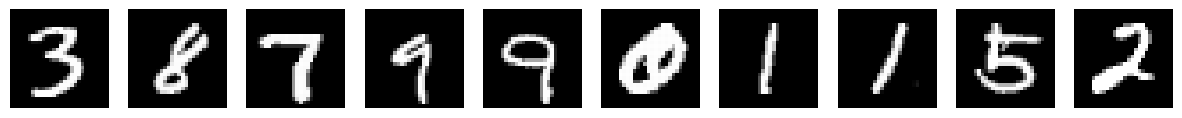

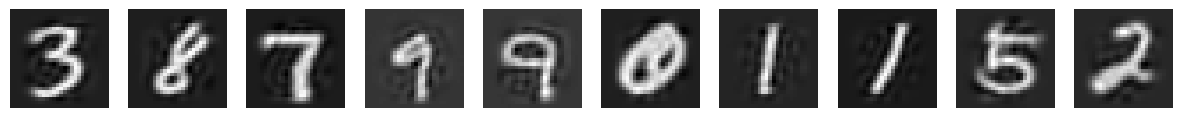

Time to add data: 0.0269 seconds
Time to search data: 3.3020 seconds
Total Brute Force time: 3.3288 seconds
Test Error: 0.0287


In [20]:
import faiss

# Select number of dimensions that explains 90% of variance
M = np.argmax(cumulative_variance >= 0.9) + 1
print(M)

# Display first 10 samples before and after PCA compression

pca_M = PCA(n_components = M)
compressed_train = pca_M.fit_transform(x_train)
compressed = pca_M.inverse_transform(compressed_train[:10])
compressed_test = pca_M.transform(x_test)

print(x_train.shape)
print(compressed_train.shape)
print(compressed_test.shape)


display_mnist(x_train[:10], 1, 10) # before compression
display_mnist(compressed, 1, 10) # after compression

# Initialize index for Brute Force
start_time = time.time()
A = np.zeros((M, 30))
index = faiss.IndexFlatL2(A.shape[0])

# Add Data & Print time to add

index.add(compressed_train)
add_time = time.time() - start_time
print(f"Time to add data: {add_time:.4f} seconds")

# Perform Search and Compute Time required
start_time = time.time()
dist, idx = index.search(compressed_test, 1)
search_time = time.time() - start_time
print(f"Time to search data: {time.time() - start_time:.4f} seconds")


total_time = add_time + search_time
print(f"Total Brute Force time: {total_time:.4f} seconds")

# Compute Test Error
y_pred = y_train[idx.flatten()]
test_error = 1 - np.mean(y_pred == y_test)
print(f"Test Error: {test_error:.4f}")


## PCA on Kite Image

Principal Component 1:
Cropped Image PDF: [0.00486206 0.00191536 0.0025047  0.00224686 0.00346237 0.00335187
 0.0031677  0.00405171 0.00526723 0.00784559 0.00942944 0.01543335
 0.02478913 0.02604147 0.0224686  0.01517551 0.00880327 0.00666691
 0.00732992 0.00574607 0.00486206 0.00445689 0.00324137 0.00320454
 0.00287303 0.00313087 0.00221003 0.00213636 0.00243103 0.00147335
 0.00217319 0.00165752 0.00257836 0.00187852 0.00165752 0.00213636
 0.00206269 0.00173119 0.00254153 0.00191536 0.00173119 0.00268887
 0.00228369 0.0025047  0.0026152  0.00324137 0.00449372 0.00504623
 0.00489889 0.00604074 0.00622491 0.00799293 0.01001879 0.01068179
 0.01149214 0.01219198 0.01576485 0.01919039 0.02453129 0.03502891
 0.03270839 0.02725699 0.01683303 0.0116763  0.01105013 0.01020295
 0.00968728 0.00906111 0.00788243 0.00721942 0.00740359 0.00526723
 0.00581974 0.00674058 0.00699842 0.00593024 0.0058934  0.00758776
 0.00769826 0.00847177 0.0112343  0.01009245 0.01060813 0.00909794
 0.00887694 0.007329

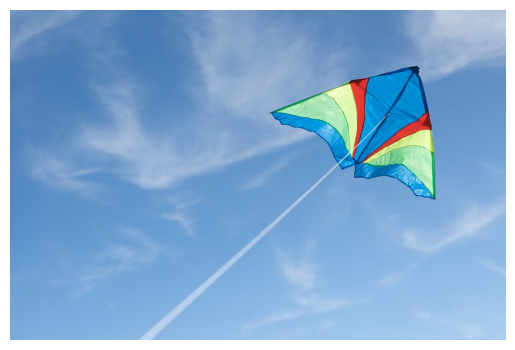

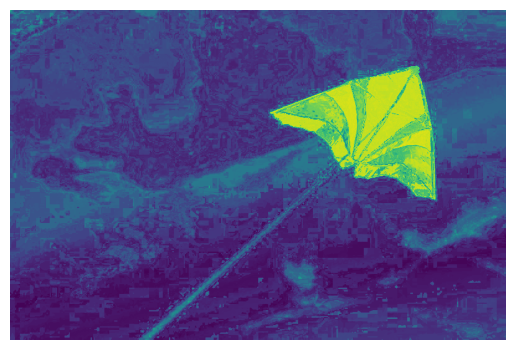

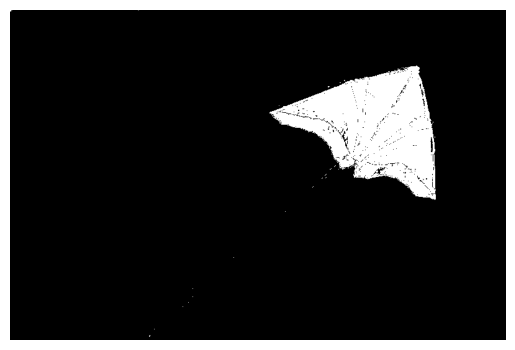

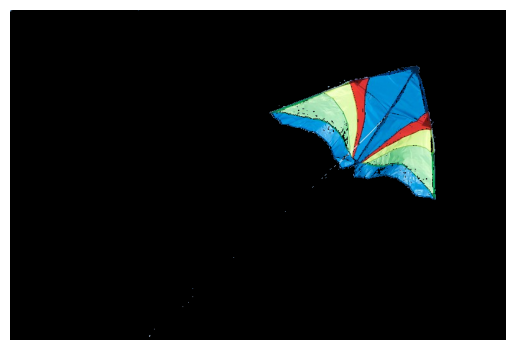

In [ ]:

import numpy as np
from sklearn.decomposition import PCA

# Set the number of bins K
K = 150

# Reshape pixels of the image and the crop to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# Perform PCA on the full image and the cropped image
pca = PCA(n_components=3)
im_pca = pca.fit_transform(full_pixels)
crop_pca = pca.transform(crop_pixels)

# Convert continuous pixel values to discrete values ranging from 0 to K-1
full_discrete = np.minimum((im_pca * K), K - 1)
crop_discrete = np.minimum((crop_pca * K), K - 1)

# Get pdf for each dimension using my estimate_discrete_pdf function
pdfs_crop = []
pdfs_full = []
for d in range(3):
    pdf_crop = estimate_discrete_pdf(crop_discrete[:, d], K)
    pdf_full = estimate_discrete_pdf(full_discrete[:, d], K)
    pdfs_crop.append(pdf_crop)
    pdfs_full.append(pdf_full)

    # Print the PDFs for each principal component
    print(f"Principal Component {d + 1}:")
    print("Cropped Image PDF:", pdf_crop)
    print("Full Image PDF:", pdf_full)
    print()

# Estimate score for each pixel in the full image according to log ratio of pdfs
score_map = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        pixel = full_discrete[i * im.shape[1] + j]
        score_map[i, j] = np.sum([np.log(pdfs_crop[d][pixel[d]] / pdfs_full[d][pixel[d]]) for d in range(3)])

# Display the results using a threshold value
thresh = 2
display_score_maps(im, score_map, thresh)


## PDF Estimation, PCA, t-SNE, and MDS on my own hibiscus image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


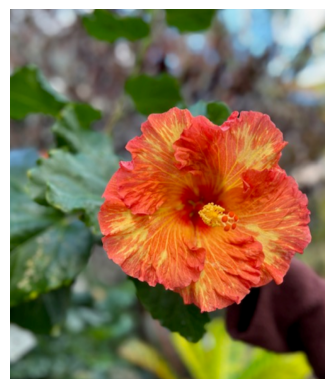

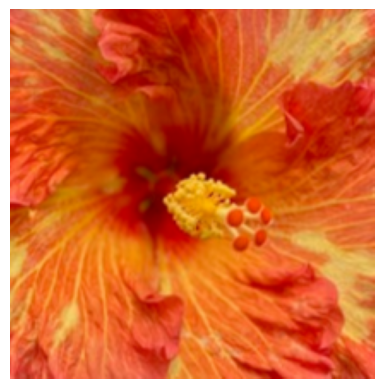

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/"
im = cv2.imread(datadir + 'Hibiscus.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + 'hib_crop.png')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
plt.imshow(im)
plt.axis('off')
plt.show()
plt.imshow(crop)
plt.axis('off')
plt.show()

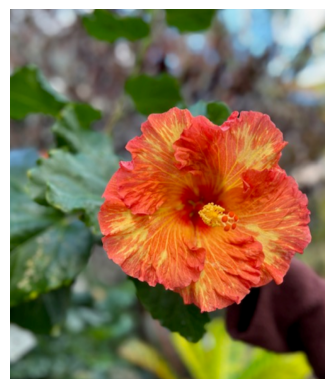

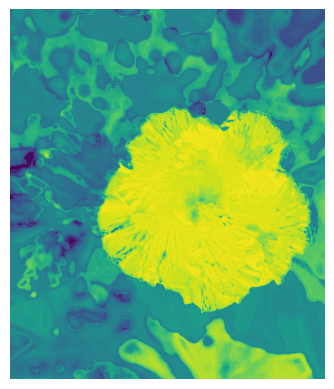

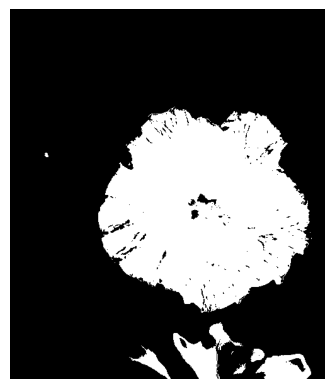

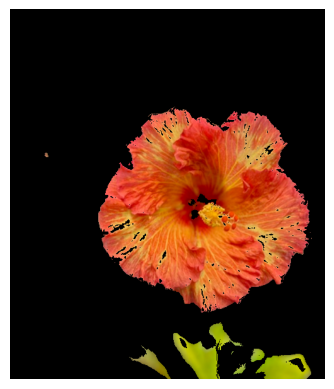

In [ ]:
# set number of bins K
K = 40

# reshape pixels to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# convert continuous values to discrete values ranging from 0 to K-1
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
full_discrete = np.minimum((full_pixels * K).astype(int), K - 1)
crop_discrete = np.minimum((crop_pixels * K).astype(int), K - 1)

# get pdf for each dimension using estimate_discrete_pdf
pdfs_crop = []
pdfs_full = []
for d in range(3):
    pdfs_crop.append(estimate_discrete_pdf(crop_discrete[:, d], K))
    pdfs_full.append(estimate_discrete_pdf(full_discrete[:, d], K))

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        pixel = full_discrete[i * im.shape[1] + j]
        score_map[i, j] = np.sum([np.log(pdfs_crop[d][pixel[d]] / pdfs_full[d][pixel[d]]) for d in range(3)])

# display
thresh = -1
display_score_maps(im, score_map, thresh)

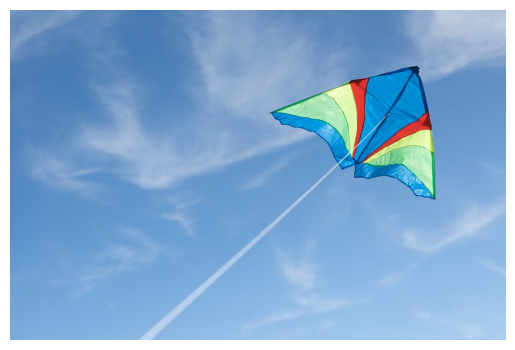

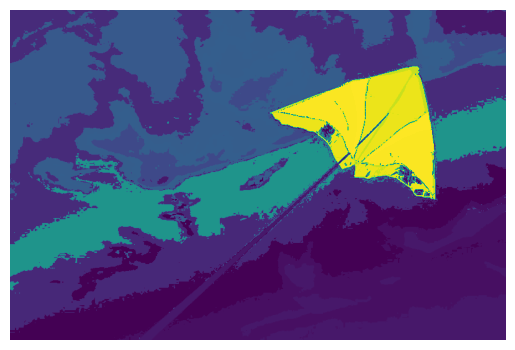

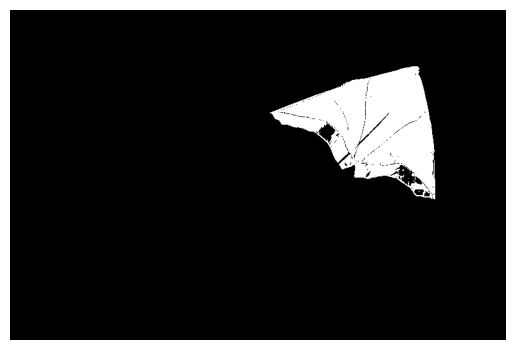

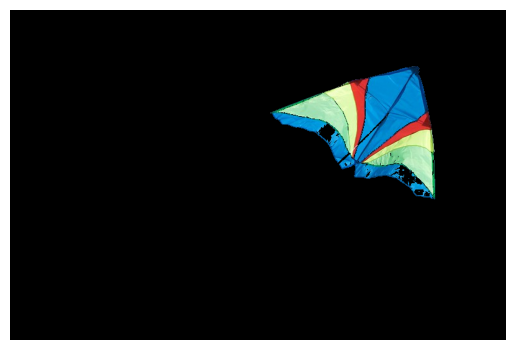

In [24]:
import faiss

# set K
K = 16
# reshape pixels to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# discretize all three color channels together using KMeans
kmeans = faiss.Kmeans(3, K, niter=20)
kmeans.train(full_pixels)
_, im_cluster_ids = kmeans.index.search(full_pixels, 1)
_, crop_cluster_ids = kmeans.index.search(crop_pixels, 1)

# get pdf over discrete values
pdf_full = estimate_discrete_pdf(im_cluster_ids.flatten(), K)
pdf_crop = estimate_discrete_pdf(crop_cluster_ids.flatten(), K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros(im.shape[:2])
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        cluster_id = im_cluster_ids[i * im.shape[1] + j]
        score_map[i, j] = np.log(pdf_crop[cluster_id] / pdf_full[cluster_id])

# display
thresh = 0
display_score_maps(im, score_map, thresh)

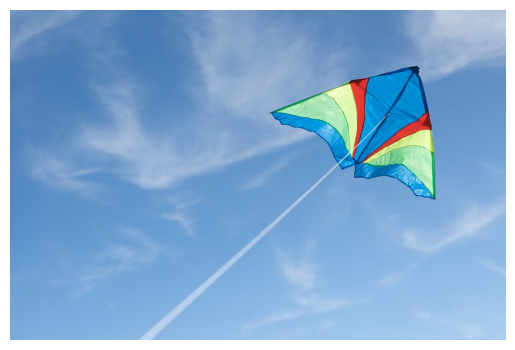

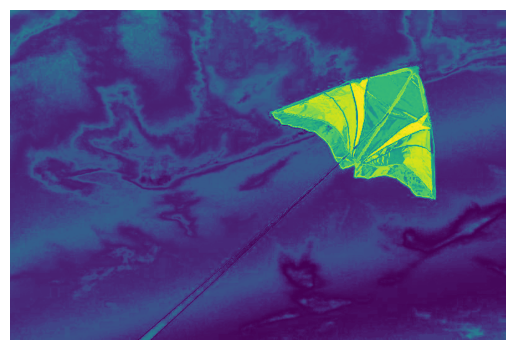

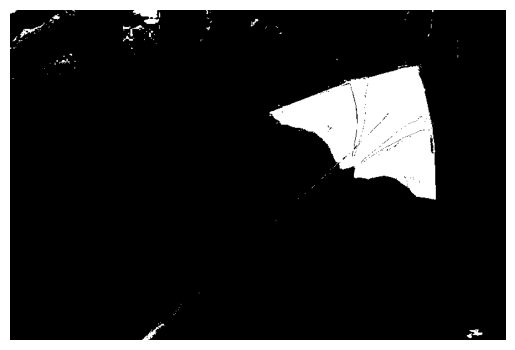

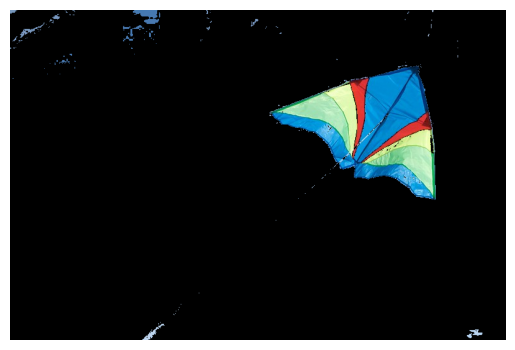

In [23]:
from sklearn.mixture import GaussianMixture

# reshape to (h*w, 3)
full_pixels = im.reshape(-1, 3)
crop_pixels = crop.reshape(-1, 3)

# get joint pdf using GMMs
gmm_full = GaussianMixture(n_components=5, covariance_type='diag')
gmm_full.fit(full_pixels)

gmm_crop = GaussianMixture(n_components=5, covariance_type='diag')
gmm_crop.fit(crop_pixels)

# estimate score for each pixel in full image according to log pdfs
log_pdf_full = gmm_full.score_samples(full_pixels)
log_pdf_crop = gmm_crop.score_samples(full_pixels)
score_map = log_pdf_crop - log_pdf_full
score_map = score_map.reshape(im.shape[:2])

# display
thresh = -1
display_score_maps(im, score_map, thresh)

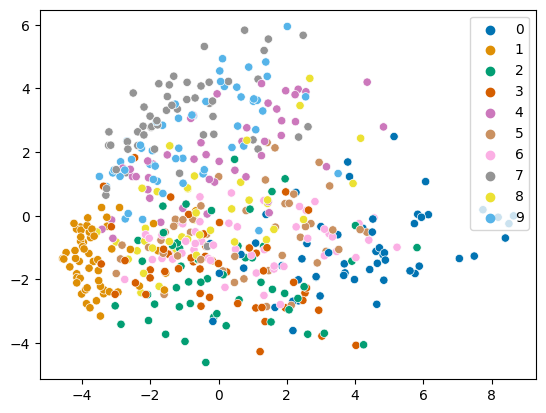

In [21]:
# Scatter plot of first two PCA dimensions
import seaborn as sns
pca_s = PCA(n_components=2)
pca_s.fit(x_train[train_indices['s']])

# Project data onto first two principal components
pca_data = pca_s.transform(x_train[train_indices['s']])

# Create a scatter plot of PCA data
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=y_train[train_indices['s']], palette='colorblind')
plt.show()


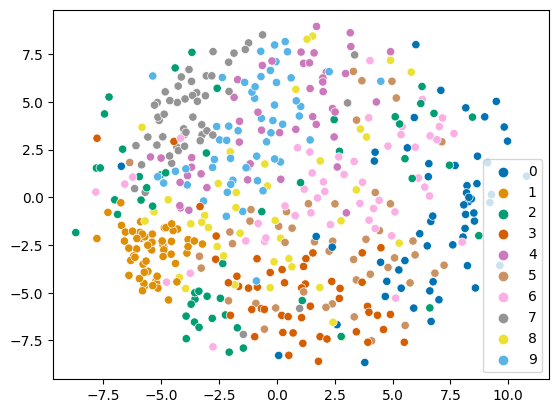

In [ ]:
# MDS
from sklearn.manifold import MDS

pca = PCA()
pca.fit(x_train)
x_pca = pca.transform(x_train)

ind = train_indices['s']
x_mds = MDS(n_components = 2, normalized_stress = 'auto').fit_transform(x_pca[ind])
sns.scatterplot(x=x_mds[ind,0], y=x_mds[ind, 1], hue=y_train[ind], palette='colorblind')
plt.show()

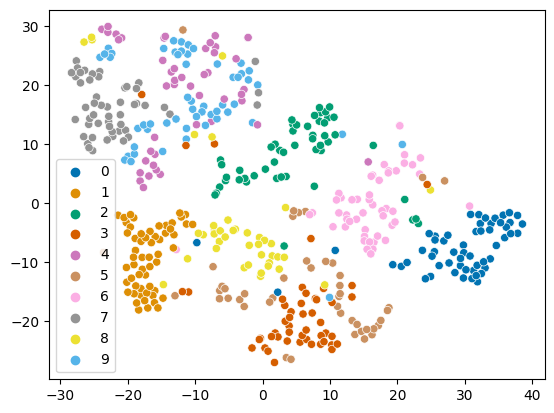

In [ ]:
#t-SNE
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state = 42).fit_transform(x_pca[ind])
sns.scatterplot(x=x_tsne[ind, 0], y=x_tsne[ind, 1], hue=y_train[ind], palette='colorblind')
plt.show()
